In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import pydicom as pyd
import SimpleITK as sk
import math
import numpy as np
from numpy import savetxt
import torch
import torchio as tio
import itk
import os

In [2]:
class DICOM_reader:
    def __init__(self):
        self.file_path = ""
        self.CT_images = []
    
    def set_path(self, path):
        self.file_path = Path(path)
    
    def extract_images(self):
        file_ids = sk.ImageSeriesReader.GetGDCMSeriesIDs(str(self.file_path))
        file_names = sk.ImageSeriesReader.GetGDCMSeriesFileNames(str(self.file_path), file_ids[0])
        series_reader = sk.ImageSeriesReader()
        series_reader.SetFileNames(file_names)
        image_data = series_reader.Execute()
        self.CT_images = sk.GetArrayFromImage(image_data)
                
    def visualize(self, images, if_all, idx=None):
        if if_all:
            idx = list(range(len(images)))
        num1 = math.ceil(math.sqrt(len(idx)))
        num2 = math.floor(math.sqrt(len(idx)))
        num1 = num1+1 if num1*num2<len(idx) else num1
        fig, axis = plt.subplots(num2, num1, figsize=(20,20))
        slice_counter = 0
        if len(idx)==1:
            axis.imshow(images[idx[slice_counter]], cmap="gray")
        else:
            if num2>1:
                for i in range(num2):
                    for j in range(num1):
                        if slice_counter<len(idx):
                            axis[i][j].imshow(images[idx[slice_counter]], cmap="gray")
                            slice_counter+=1
                        else:
                            break
            else:
                for i in range(num1):
                    axis[i].imshow(images[idx[slice_counter]], cmap="gray")
                    slice_counter+=1
                                
    def get_images(self):
        # self.CT_images = [np.expand_dims(np.array(image.astype("int32")),axis=0) for image in self.CT_images]
        return self.CT_images

In [8]:
file_path = "/Users/wangyangwu/Documents/Maastro/NeuralNets/PROTON/P0439C0006I2866736/CT/1.3.6.1.4.1.32722.228.6.55901622014571750448587355595101479465"
file_ids = sk.ImageSeriesReader.GetGDCMSeriesIDs(str(file_path))
file_names = sk.ImageSeriesReader.GetGDCMSeriesFileNames(str(file_path), file_ids[0])
series_reader = sk.ImageSeriesReader()
series_reader.SetFileNames(file_names)
image_data = series_reader.Execute()
CT_images = sk.GetArrayFromImage(image_data)

In [ ]:
np.max(CT_images)

In [20]:
import pydicom as dc
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pylab as plt
import SimpleITK as sk
from dicom_contour.contour import get_contour_file, get_roi_names, get_data, fill_contour

## EXTRACT CT AND DOSE IMAGES FOMR DICOM
#folder_path: path for folder which contains CT dicoms
def extract_images(path):
    #path = Path(folder_path)
    file_ids = sk.ImageSeriesReader.GetGDCMSeriesIDs(str(path))
    file_names = sk.ImageSeriesReader.GetGDCMSeriesFileNames(str(path), file_ids[0])
    series_reader = sk.ImageSeriesReader()
    series_reader.SetFileNames(file_names)
    
    image_data = series_reader.Execute()
    
    return image_data

def get_image_info(image):
    xCTspace = image.GetSpacing()[0]
    yCTspace = image.GetSpacing()[1]
    zCTspace = image.GetSpacing()[2]
    x_ct = image.GetOrigin()[0]  # x image corner
    y_ct = image.GetOrigin()[1]  # y image corner
    z_ct = image.GetOrigin()[2] # z image corner
    
    return xCTspace, yCTspace, zCTspace, x_ct, y_ct, z_ct


## GET STRUCTURE CONTOURS FROM FILES
#path: path for a folder which contains both CT dicom and RTStruct dicom
#ROI_names: list containing names of all ROI you need
def get_struct_contours(path:str, ROI_names:list):
    contours_list = []
    #store dicom file
    contour_file = get_contour_file(path)
    contour_data = dc.read_file(path + '/' + contour_file)
    ROI_list = get_roi_names(contour_data)
    print(ROI_list)
    target_ROI_index = []
    for name in ROI_names:
        for t in ROI_list:
            if name.lower()=="body1" and t.lower()=="body":   
                target_ROI_index.append(ROI_list.index(t))
            elif name.lower()=="lungs-gtv" and t.lower()=="lungs-gtv1":
                target_ROI_index.append(ROI_list.index(t))
            elif name.lower()==t.lower():
                target_ROI_index.append(ROI_list.index(t))
                
    # images, contours = get_data(path, index=target_ROI_index[0])
    for index in target_ROI_index:
        images, contours = get_data(path, index=index)
        #get contour maps
        contour_slices = [contours[i] for i in range(contours.shape[0])]
        contour_3d = [fill_contour(c) if c.max()==1 else c for c in contour_slices]
        contour_3d = np.stack(contour_3d)
        contours_list.append(contour_3d)
    return contours_list

def extract_plan(path, xCTspace, yCTspace, zCTspace, x_ct, y_ct, z_ct, mask_3d):
    #read and convert plan
    plan = dc.read_file(path)
    
    bs = plan.IonBeamSequence
    
    beam_array = np.zeros(mask_3d.shape)
    
    for beam in bs:
        beam_para = beam.IonControlPointSequence[0]
        isocenter = beam_para.IsocenterPosition
        gantry =  float(beam_para.GantryAngle)
        couch = float(beam_para.PatientSupportAngle)
        
        #find isocenter position in the image space
        x_iso = int(round(abs(x_ct - isocenter[0])/xCTspace, 0))
        y_iso = -int(round(abs(y_ct - isocenter[1])/yCTspace, 0))
        z_iso = int(round(abs(z_ct - isocenter[2])/zCTspace, 0))
        
        #position of image points
        contour_x = np.where(mask_3d == True)[2] - x_iso
        contour_y = -np.where(mask_3d == True)[1] - y_iso
        contour_z = np.where(mask_3d == True)[0] - z_iso
        
        
        #couch = 190
        if couch == 270:
            couch = 0
        elif couch == 0:
            couch = -90
        else:
            couch = 270 - couch
        couch_rad = np.pi * couch /180.
        
        #gantry = 90
        if 355 <= gantry <= 360:
            gantry = 360 - gantry + 180
        elif 180 <= gantry <= 185:
            gantry = 180 - gantry
        else:
            gantry = np.abs(gantry -180) #-180 angle 0, -135 gantry 45
        gantry_rad = np.pi * gantry /180.
        
    
        rotation_matrix = np.array([[np.cos(couch_rad), 0, np.sin(couch_rad)],
                                    [np.sin(gantry_rad)*np.sin(couch_rad), np.cos(gantry_rad), -np.sin(gantry_rad)*np.cos(couch_rad)],
                                    [-np.cos(gantry_rad)*np.sin(couch_rad), np.sin(gantry_rad), np.cos(couch_rad)*np.cos(gantry_rad)]])
        
    
        p_x_iso = np.sum(np.array([x_iso, y_iso, z_iso]) * rotation_matrix[0])
        p_y_iso = np.sum(np.array([x_iso, y_iso, z_iso]) * rotation_matrix[1])
        p_z_iso = np.sum(np.array([x_iso, y_iso, z_iso]) * rotation_matrix[2])
        
        lim_x =[]
        lim_y =[]
        lim_z=[]
        for p in np.arange(len(contour_x)):
            point = np.array([contour_x[p], contour_y[p], contour_z[p]])
            lim_x.append(int(round(np.sum(point * rotation_matrix[0]) + p_x_iso, 0)))
            lim_y.append(int(round(np.sum(point * rotation_matrix[1]) + p_y_iso, 0)))
            lim_z.append(int(round(np.sum(point * rotation_matrix[2]) + p_z_iso, 0)))
        
        shift_x = np.min(lim_x)
        shift_y = np.min(lim_y)
        shift_z = np.min(lim_z) 
    
        center_shift = 100 #to avoid matrix being cut
        
        p_mask_3d = np.zeros((512, 512, 512)) # make this size bigger to capture full path
        for p in np.arange(len(lim_x)):
            p_x = lim_x[p] - shift_x + center_shift
            p_y = lim_y[p] - shift_y + center_shift
            p_z = lim_z[p] - shift_z + center_shift
            p_mask_3d[p_z, p_y, p_x] = 1
            
    
        
        p_beam = np.zeros((512, 512, 512))
        for d1 in np.arange(512, dtype = np.int64):
            for d2 in np.arange(512, dtype = np.int64):
                if np.sum(p_mask_3d[d1, :, d2]) != 0:
                    depth = np.max(np.where(p_mask_3d[d1, :, d2] == True)[0])
                    p_beam[d1, : depth, d2] = 1 
                    
        p_contour_x = np.where(p_beam == 1)[2] + shift_x - p_x_iso - center_shift
        p_contour_y = np.where(p_beam == 1)[1] + shift_y - p_y_iso - center_shift
        p_contour_z = np.where(p_beam == 1)[0] + shift_z - p_z_iso - center_shift 
        
        reverse_rotation_matrix = rotation_matrix.T
        
        pp_x_iso = np.sum(np.array([p_x_iso, p_y_iso, p_z_iso]) * reverse_rotation_matrix[0])
        pp_y_iso = np.sum(np.array([p_x_iso, p_y_iso, p_z_iso]) * reverse_rotation_matrix[1])
        pp_z_iso = np.sum(np.array([p_x_iso, p_y_iso, p_z_iso]) * reverse_rotation_matrix[2])
        
        
        for p in np.arange(len(p_contour_x)):
            point = np.array([p_contour_x[p], p_contour_y[p], p_contour_z[p]])
            x = int(round(np.sum(point * reverse_rotation_matrix[0]) + pp_x_iso, 0))
            y = -int(round(np.sum(point * reverse_rotation_matrix[1]) + pp_y_iso, 0)) 
            z = int(round(np.sum(point * reverse_rotation_matrix[2]) + pp_z_iso, 0))
            if y>= beam_array.shape[1] or x>= beam_array.shape[2] or z>= beam_array.shape[0] or y<= -beam_array.shape[1] or x<= -beam_array.shape[2] or z<= -beam_array.shape[0]:
                pass
            else:
                beam_array[z, y, x] = 1
                    
    beam_array[np.where(beam_array>0)] = 1
    
    pp_y_iso = -1*pp_y_iso
    
    # plt.figure()
    # plt.imshow(im_matrix[:, :, x_iso], cmap = "Greys_r")
    # plt.imshow(mask_3d_ctv[:,:,  x_iso ], alpha = 0.2)
    # plt.imshow(beam_array[:,: , x_iso], alpha = 0.5)
    # plt.plot([pp_y_iso], [pp_z_iso], "ro")
    
    # plt.figure()
    # plt.imshow(im_matrix[:, -y_iso, :], cmap = "Greys_r")
    # plt.imshow(mask_3d_ctv[:,-y_iso,  : ], alpha = 0.2)
    # plt.imshow(beam_array[:,-y_iso , :], alpha = 0.5)
    # plt.plot([pp_x_iso], [pp_z_iso], "ro")
    
    
    # plt.figure()
    # plt.imshow(im_matrix[z_iso, :,: ], cmap = "Greys_r")
    # plt.imshow(mask_3d_ctv[z_iso,:,  :], alpha = 0.2)
    # plt.imshow(beam_array[z_iso,: , :], alpha = 0.5)
    # plt.plot([pp_x_iso], [pp_y_iso], "ro")
    
        
    return beam_array



mypath_image = "/Users/wangyangwu/Documents/Maastro/NeuralNets/sample/P0439C0006I3038573/CT/1.3.6.1.4.1.32722.228.6.142883489487996495069834912917600503695"
#path to the plan file
mypath_plan = "/Users/wangyangwu/Documents/Maastro/NeuralNets/sample/P0439C0006I3038573/RTPLAN/1.3.6.1.4.1.32722.228.6.234760996457273488538121226897335269573/1.3.6.1.4.1.32722.228.6.301878774919887321488919281322497406169.dcm"

#read CT image and mask
image = extract_images(mypath_image)
im_matrix = sk.GetArrayFromImage(image)
xCTspace, yCTspace, zCTspace, x_ct, y_ct, z_ct = get_image_info(image)
del image

mask_3d = get_struct_contours(mypath_image, ["CTV1"])
mask_3d_ctv = mask_3d[0]

#beam_array is a matrix representing beam directions with 1 where beam is expected and 0 otherwise
#it has the same dimentions as image and contour
beam_array = extract_plan(mypath_plan, xCTspace, yCTspace, zCTspace, x_ct, y_ct, z_ct, mask_3d_ctv)

['mid_1', 'mid_0', 'mid_2', 'isogem', 'Rail1A', 'Rail2A', 'Lung_treatment_T', 'Lung R-CTV_03', 'Heart-CTV_05', 'CTV1', 'External1', 'Spinal Cord_3', 'Lungs-GTV', 'MedEnv_05', 'MediastEnvelop', 'Heart', 'CTVnsum_05', 'GTVnsum', 'Spinal Cord', 'Esophagus', 'Lung R', 'Lung L', 'BODY1']


In [12]:
a = np.random.rand(1,2,3,4)

In [13]:
a.shape

(1, 2, 3, 4)

In [17]:
np.concatenate((a,a)).shape

(2, 2, 3, 4)

In [21]:
beam_array.shape

(159, 512, 544)

In [1]:
path = "/Users/wangyangwu/Documents/Maastro/NeuralNets/Processed_data/preprocessed_data_compressed_npz['CTV1']/P0439C0006I2866736/label.npz"

In [4]:
y = np.load(path,allow_pickle=False)['arr_0']

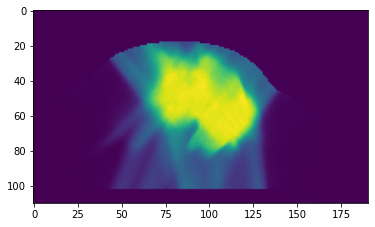

In [6]:
plt.imshow(y[0][60])

In [17]:
y[0].sum()

7642585.716826041

In [18]:
y[0] = y[0]/100

In [19]:
y[0].sum()

76425.85716826047

In [3]:
import torch.nn as nn
import torch

In [13]:
a = torch.rand(2,2,3,4,5)

In [25]:
a[1,1,:,:,:].sum()

tensor(27.8915)